# Electron Collision Mass Predictor Model

This project explores a dataset sourced from the CERN Open Data Portal, titled "CERN Electron Collision Data." The dataset, as described by McCauley, Thomas (2014) and available at https://opendata.cern.ch/record/304, contains information from 100,000 dielectron events.

The primary goal of this project is to apply machine learning regression techniques to this dataset. Specifically, I aim to build and evaluate models that can predict the invariant mass (M) of the dielectron system using the kinematic properties (energy, momentum components, direction) of the two detected electrons as input features. This involves exploring the data, preprocessing it appropriately, training various regression algorithms, tuning their hyperparameters, and evaluating their performance to understand how well these kinematic features can determine the invariant mass.

### Import Necessary Libraries

In [ ]:
!pip install scikit-learn pandas numpy seaborn matplotlib xgboost cudf-cu12 cuml-cu12 cupy-cuda12x dask_ml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requ

In [ ]:
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cudf
import cupy as cp
import cuml

### Data Exploritory Analysis

In [ ]:
df = cudf.read_csv("dielectron.csv")
df.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [ ]:
df.shape

(100000, 19)

In [ ]:
# Clean column name
df.columns

df.rename(columns={'px1 ': 'px1'}, inplace=True)

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.311320,10.531000,-57.29740,12.82020,-2.202670,2.177660,1,11.28360,-1.032340,-1.88066,-11.077800,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.152130,-0.579855,-5.11278,4.19242,-1.028420,-3.002840,-1,17.14920,-11.713500,5.04474,11.464700,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.480900,2.041680,22.72460,11.66100,1.420480,2.965600,1,15.82030,-1.472800,2.25895,-15.588800,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.512140,11.887100,63.86620,14.06190,2.218380,1.007210,1,25.12730,4.087860,2.59641,24.656300,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.952840,-14.622700,-59.61210,14.91790,-2.093750,-1.371540,-1,13.88710,-0.277757,-2.42560,-13.670800,2.44145,-2.423700,-1.684810,-1,2.74718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,146511,522575834,12.31310,-10.658000,5.164440,3.36858,11.84330,0.280727,2.690370,-1,1.80181,0.668609,-1.58437,0.537805,1.71967,0.307851,-1.171470,1,8.44779
99996,146511,522786431,18.46420,7.854990,15.133000,-7.08659,17.05020,-0.404510,1.092010,1,14.69110,-1.418020,-2.28117,-14.443500,2.68598,-2.383880,-2.126960,1,20.71540
99997,146511,522906124,4.18566,-3.273500,-0.308507,-2.59013,3.28801,-0.723075,-3.047630,1,72.81740,-11.074900,-9.28179,-71.369300,14.45010,-2.300410,-2.444050,-1,12.71350
99998,146511,523243830,54.46220,11.352600,11.880900,51.92400,16.43280,1.867800,0.808132,-1,8.58671,0.378009,3.07828,8.007050,3.10141,1.677170,1.448610,1,4.69670


In [ ]:
df.nunique()

Run         13
Event    99976
E1       95669
px1      97213
py1      97153
pz1      98152
pt1      91788
eta1     94037
phi1     94641
Q1           2
E2       95425
px2      97392
py2      97410
pz2      97924
pt2      92789
eta2     89752
phi2     94494
Q2           2
M        93244
dtype: int64

In [ ]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   Run     100000 non-null  int64
 1   Event   100000 non-null  int64
 2   E1      100000 non-null  float64
 3   px1     100000 non-null  float64
 4   py1     100000 non-null  float64
 5   pz1     100000 non-null  float64
 6   pt1     100000 non-null  float64
 7   eta1    100000 non-null  float64
 8   phi1    100000 non-null  float64
 9   Q1      100000 non-null  int64
 10  E2      100000 non-null  float64
 11  px2     100000 non-null  float64
 12  py2     100000 non-null  float64
 13  pz2     100000 non-null  float64
 14  pt2     100000 non-null  float64
 15  eta2    100000 non-null  float64
 16  phi2    100000 non-null  float64
 17  Q2      100000 non-null  int64
 18  M       99915 non-null   float64
dtypes: float64(15), int64(4)
memory usage: 14.5 MB


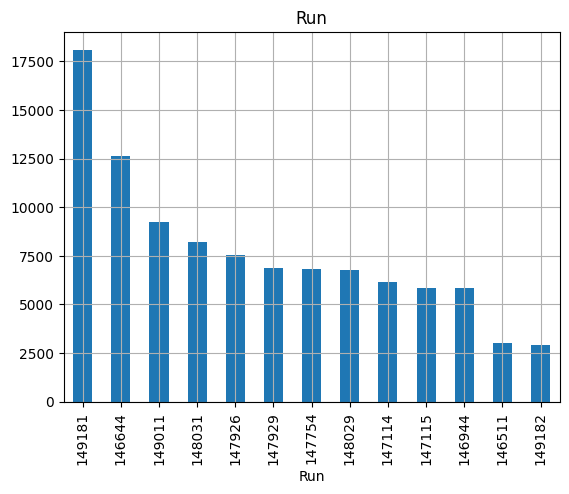

In [ ]:
run_counts_gpu = df["Run"].value_counts()
run_counts_cpu = run_counts_gpu.to_pandas()

run_counts_cpu.plot(kind='bar')
plt.grid()
plt.title('Run')
plt.show()

In [ ]:
num_duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicate_rows}")
df.duplicated(keep=False)

all_duplicate_occurrences = df[df.duplicated(keep=False)]

df.drop_duplicates(keep='first', inplace=True)


Number of duplicate rows: 23


In [ ]:
df.isna().sum()

Run       0
Event     0
E1        0
px1       0
py1       0
pz1       0
pt1       0
eta1      0
phi1      0
Q1        0
E2        0
px2       0
py2       0
pz2       0
pt2       0
eta2      0
phi2      0
Q2        0
M        85
dtype: int64

In [ ]:
df.describe()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
count,99977.000000,9.997700e+04,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99977.000000,99892.000000
mean,147935.444972,4.957273e+08,36.436050,0.136422,0.182525,-1.511318,14.411852,-0.064172,0.021571,-0.005451,44.005046,-0.003445,0.124291,-1.588849,13.802947,-0.072845,0.021280,-0.004251,30.020882
std,920.332410,4.038148e+08,41.214202,13.404566,13.470672,51.601666,12.389097,1.462154,1.799564,0.999990,46.752755,13.127970,13.169872,61.432520,12.461194,1.738055,1.816935,0.999996,25.255932
min,146511.000000,6.414000e+03,0.377928,-250.587000,-126.079000,-840.987000,0.219629,-4.165380,-3.141580,-1.000000,0.472500,-233.730000,-145.651000,-655.396000,0.026651,-7.064790,-3.141580,-1.000000,2.000080
25%,147114.000000,2.023271e+08,8.457250,-5.233210,-5.277350,-15.861800,3.770630,-1.283920,-1.527180,-1.000000,11.057200,-4.794580,-4.607830,-22.036900,3.738800,-1.892320,-1.556920,-1.000000,12.445850
50%,147929.000000,3.902231e+08,21.717100,0.141213,0.098888,-0.313493,12.967500,-0.061290,0.034367,-1.000000,25.265200,-0.034957,0.083522,-0.690668,11.692800,-0.136034,0.026967,-1.000000,21.284100
75%,149011.000000,6.340532e+08,50.018100,5.714980,5.648000,13.209800,20.019000,1.144400,1.562340,1.000000,66.926800,4.820140,5.062070,19.008400,19.597500,1.768260,1.596570,1.000000,39.028550
max,149182.000000,1.791247e+09,850.602000,134.539000,147.467000,760.096000,265.578000,2.622970,3.141420,1.000000,948.375000,227.330000,166.283000,935.558000,281.654000,3.060550,3.141290,1.000000,109.999000


In [ ]:
df.dropna(inplace=True)
df.drop(columns=['Run','Event'],inplace=True)
df.head()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


### Feature Engineering

The model is trying to predict $M$ which is: $M = \sqrt{(E_1 + E_2)^2 - ((p_{1_{x}} + p_{2_{x}})^2 + (p_{1_{y}} + p_{2_{y}})^2 + (p_{1_{z}} + p_{2_{z}})^2)}$

$E_{sum} = E_1 + E_2$

$P_{x,sys} = px_1 + px_2$

$P_{y,sys} = py_1 + py_2$

$P_{z,sys} = pz_1 + pz_2$

$P_{T,sys} = \sqrt{P_{x,sys}^2 + P_{y,sys}^2} = \sqrt{(px_1+px_2)^2 + (py_1+py_2)^2}$

$E_{asymmetry} = \frac{E_1 - E_2}{E_1 + E_2 + \epsilon}$

$P_{T,asymmetry} = \frac{pt_1 - pt_2}{pt_1 + pt_2 + \epsilon}$

$Q_{product} = Q_1 \times Q_2$

In [ ]:
df_fe = df.copy()
epsilon = 1e-9

df_fe['delta_eta'] = df_fe['eta1'] - df_fe['eta2']
df_fe['dphi'] = df_fe['phi1'] - df_fe['phi2']

df_fe['dphi'] = df_fe['dphi'].where(df_fe['dphi'] <= cp.pi, df_fe['dphi'] - 2 * cp.pi)
df_fe['dphi'] = df_fe['dphi'].where(df_fe['dphi'] > -cp.pi, df_fe['dphi'] + 2 * cp.pi)
df_fe['delta_R'] = cp.sqrt(df_fe['delta_eta']**2 + df_fe['dphi']**2)

df_fe['E_sum'] = df_fe['E1'] + df_fe['E2']

df_fe['system_px'] = df_fe['px1'] + df_fe['px2']
df_fe['system_py'] = df_fe['py1'] + df_fe['py2']
df_fe['system_pz'] = df_fe['pz1'] + df_fe['pz2']
df_fe['system_pt_mag'] = cp.sqrt(df_fe['system_px']**2 + df_fe['system_py']**2)

df_fe['Q_product'] = df_fe['Q1'] * df_fe['Q2']

df_fe['E_asymmetry'] = (df_fe['E1'] - df_fe['E2']) / (df_fe['E_sum'] + epsilon)
df_fe['pt_asymmetry'] = (df_fe['pt1'] - df_fe['pt2']) / (df_fe['pt1'] + df_fe['pt2'] + epsilon)

df_fe.drop(columns=["E1","E2","px1","px2","py1", "py2", "pz1", "pz2", "Q1","Q2",],axis=1, inplace=True)

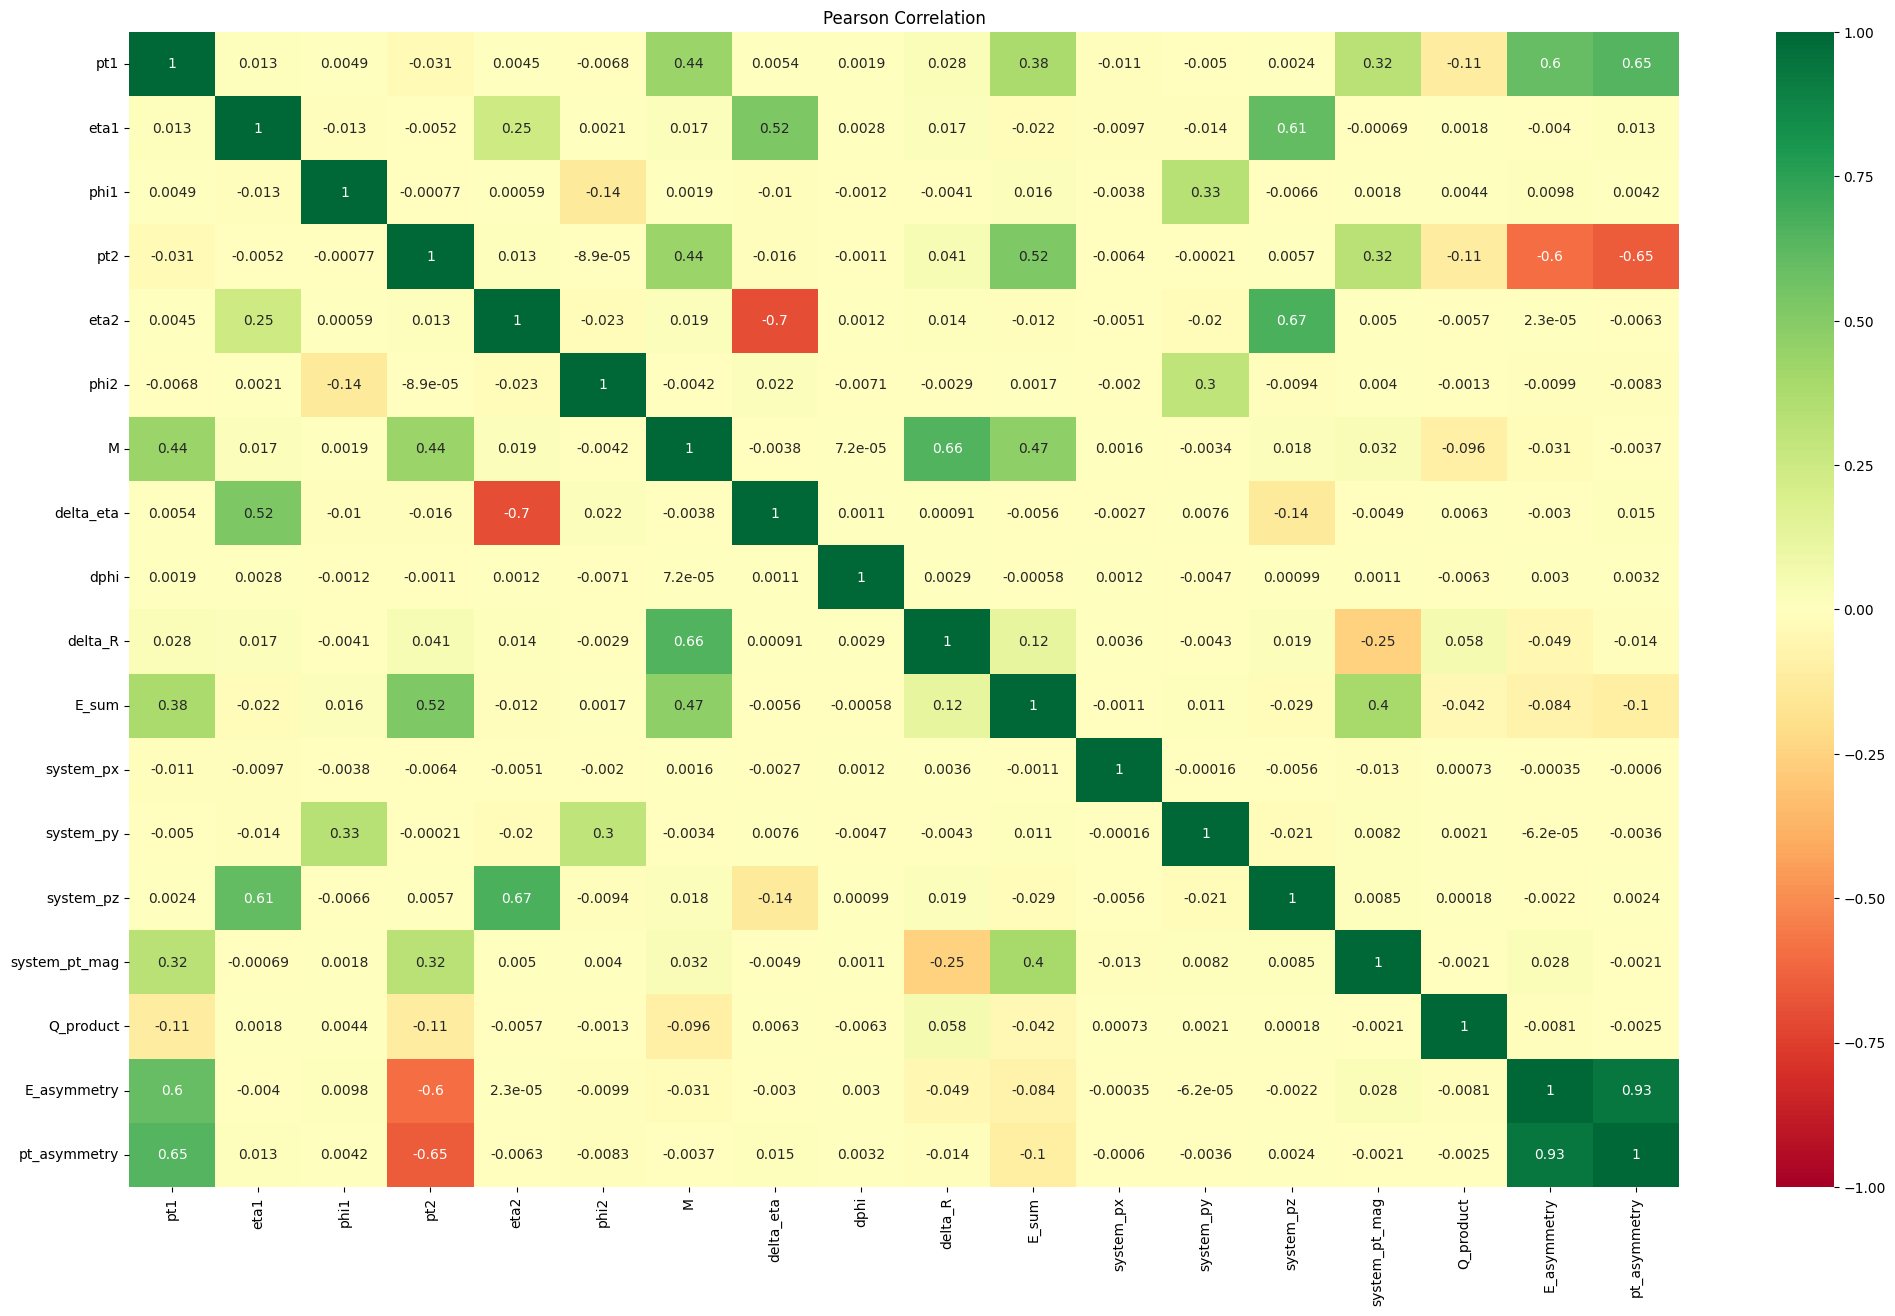

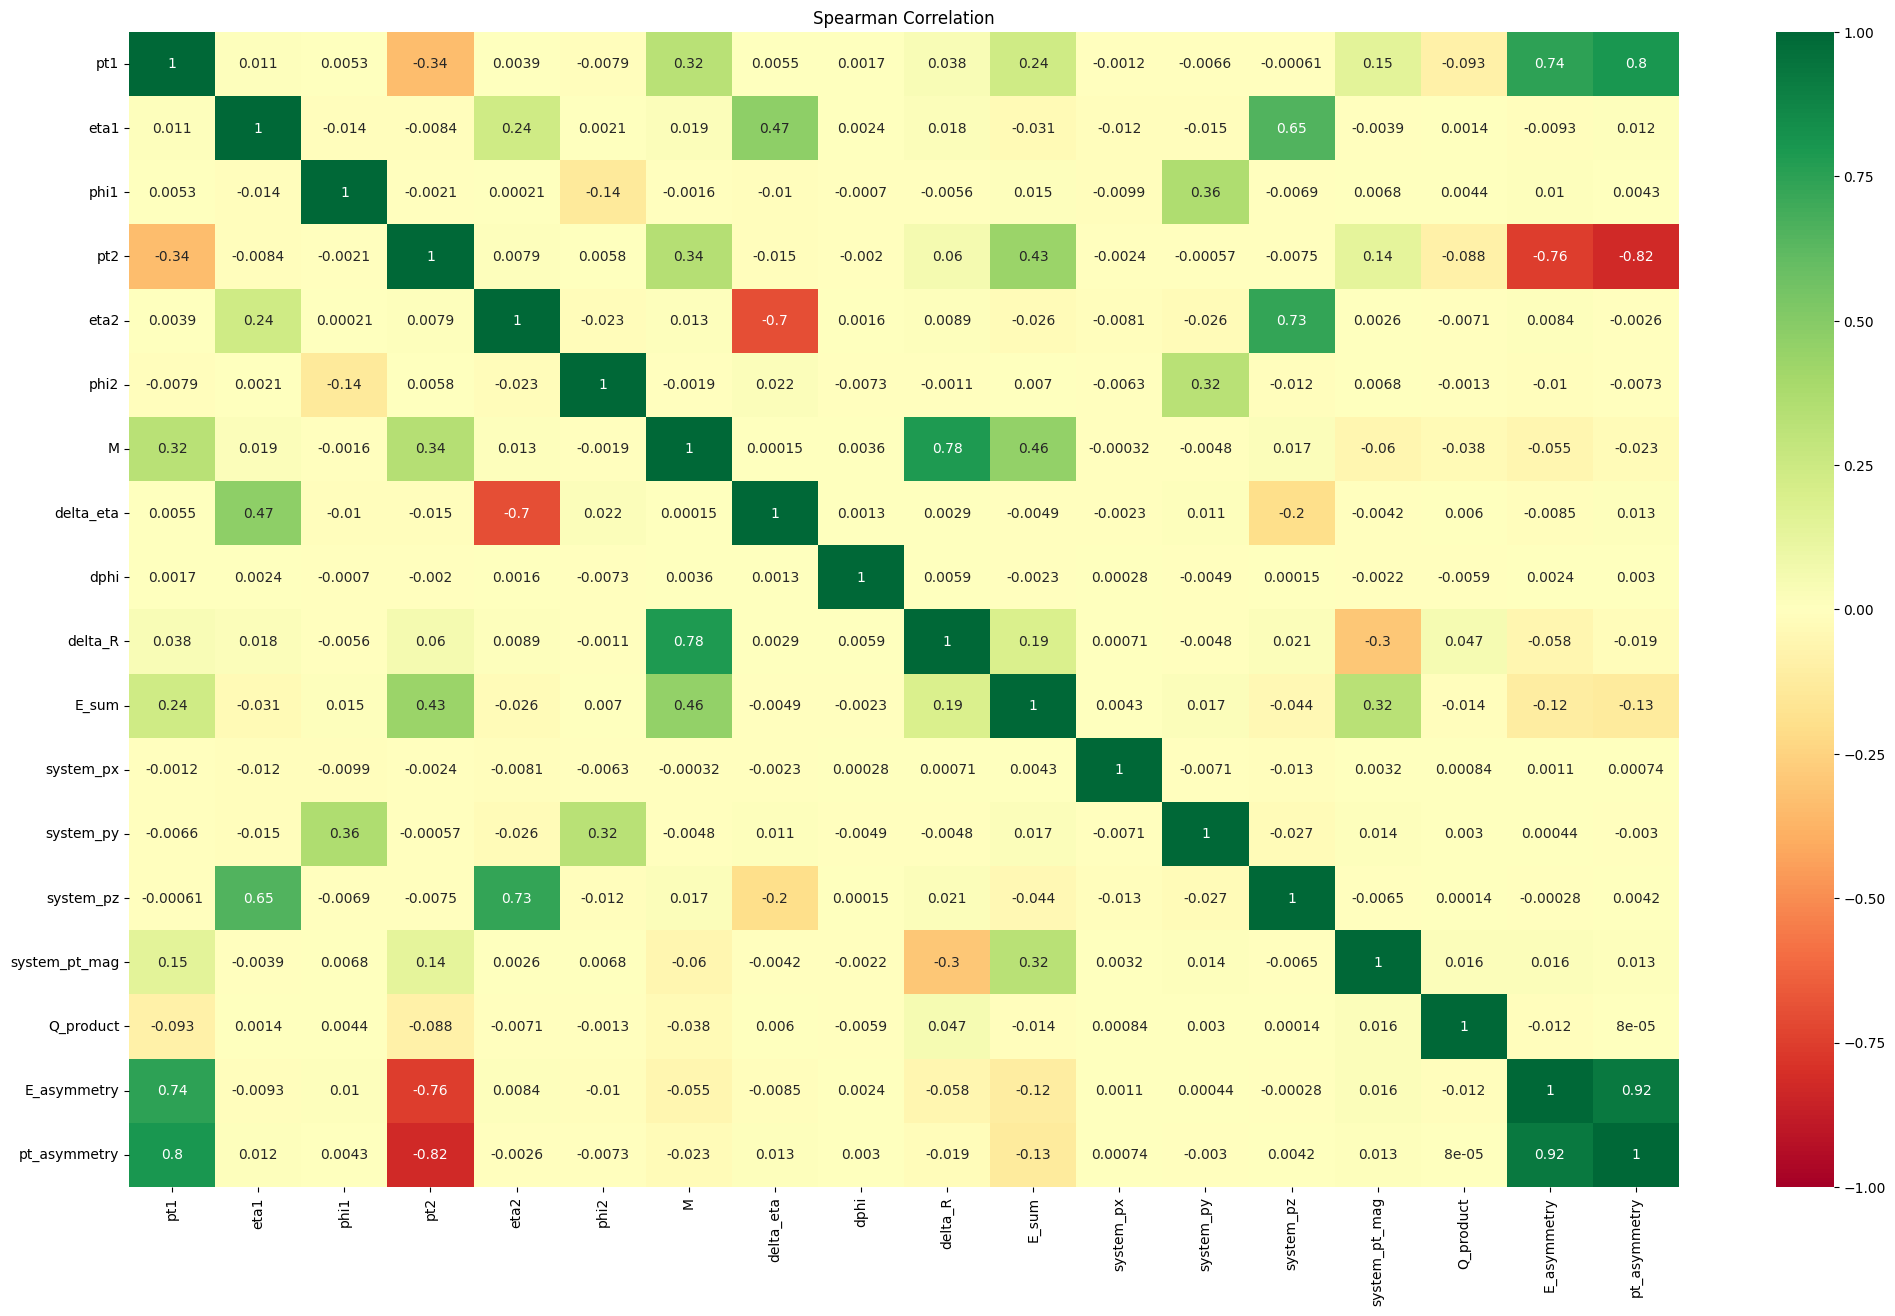

In [ ]:
corr_pearson_gpu = df_fe.corr(method='pearson')
corr_spearman_gpu = df_fe.corr(method='spearman')

corr_pearson_cpu = corr_pearson_gpu.to_pandas()
corr_spearman_cpu = corr_spearman_gpu.to_pandas()

fig = plt.figure(figsize = (25,15))

sns.heatmap(corr_pearson_cpu, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Pearson Correlation')
plt.show()

fig = plt.figure(figsize = (25,15))

sns.heatmap(corr_spearman_cpu, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Spearman Correlation')
plt.show()


The pearson and spearman correlation heatmaps show that

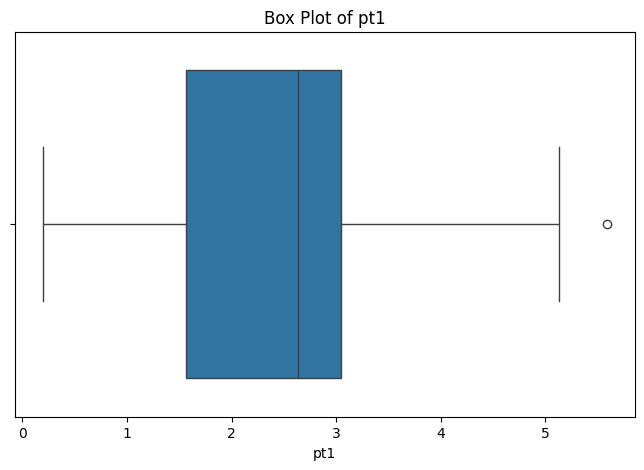

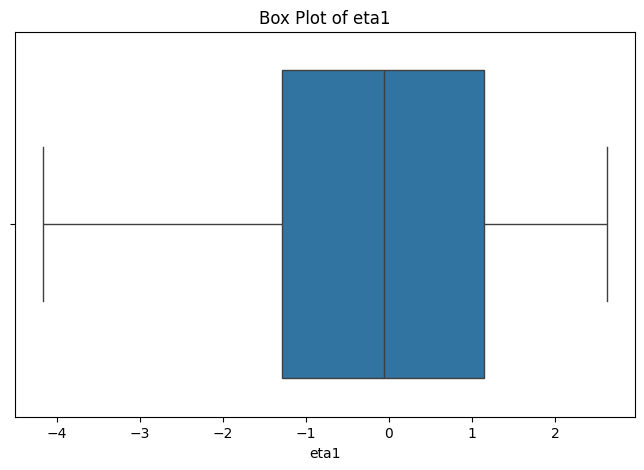

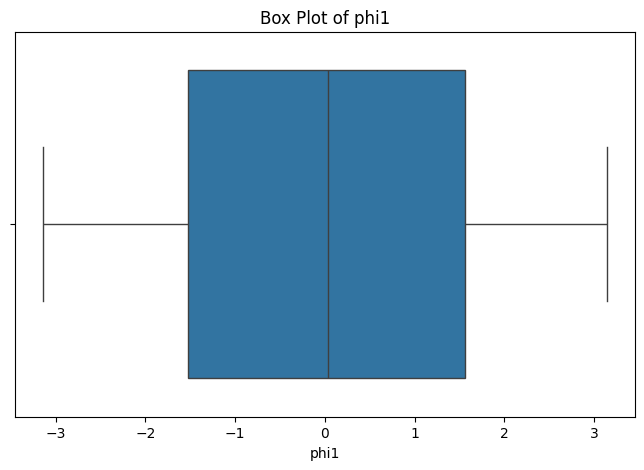

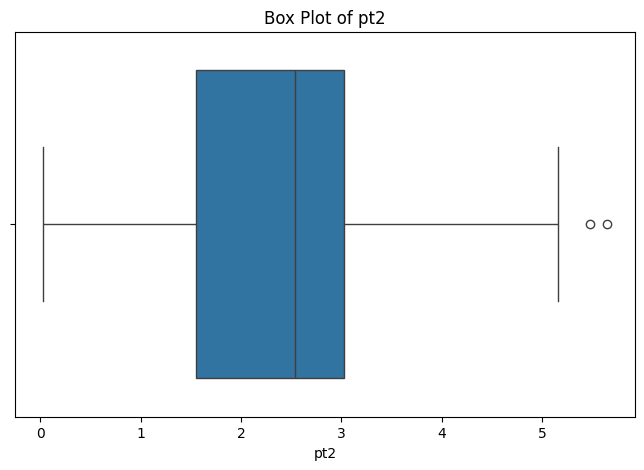

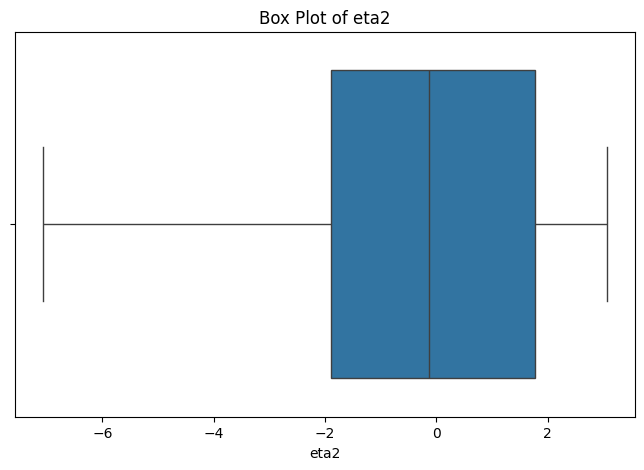

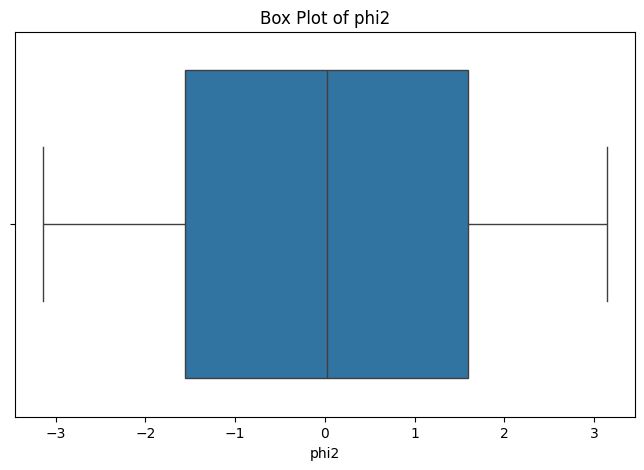

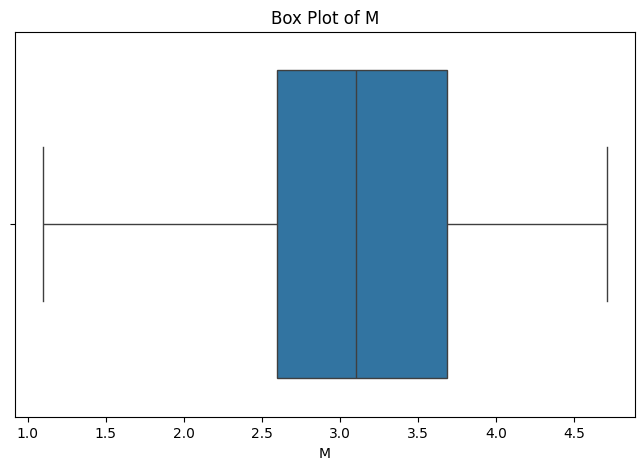

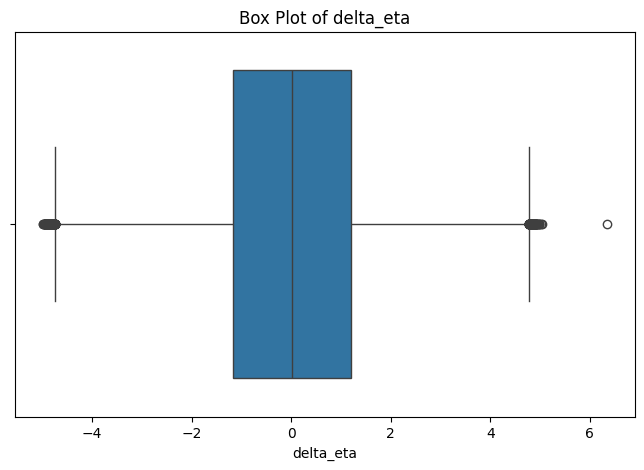

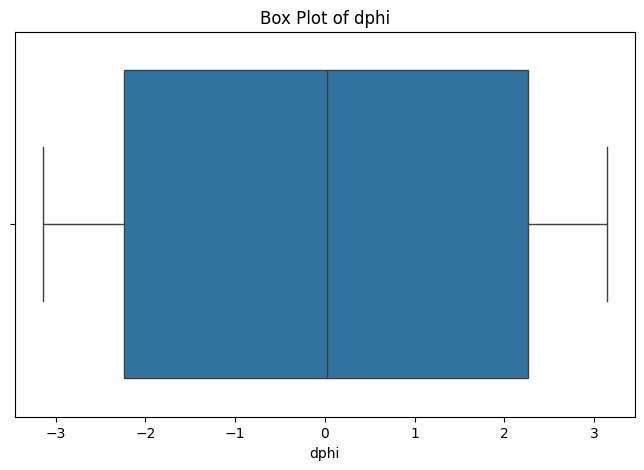

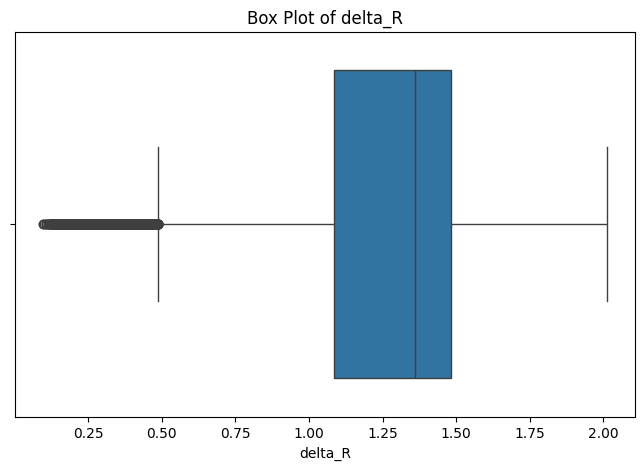

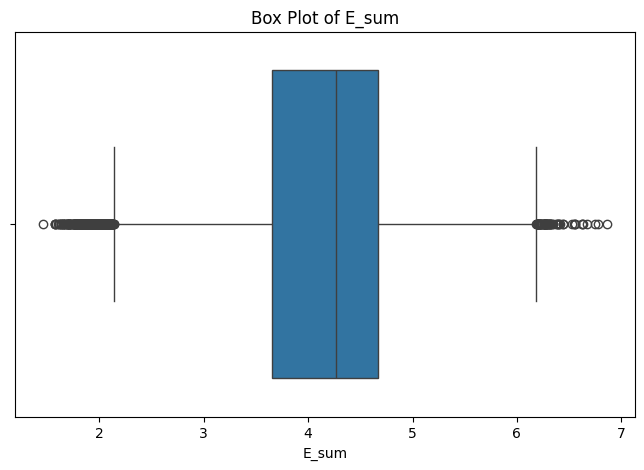

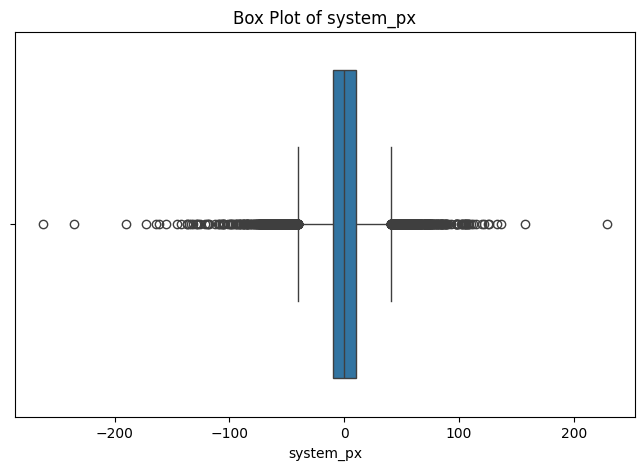

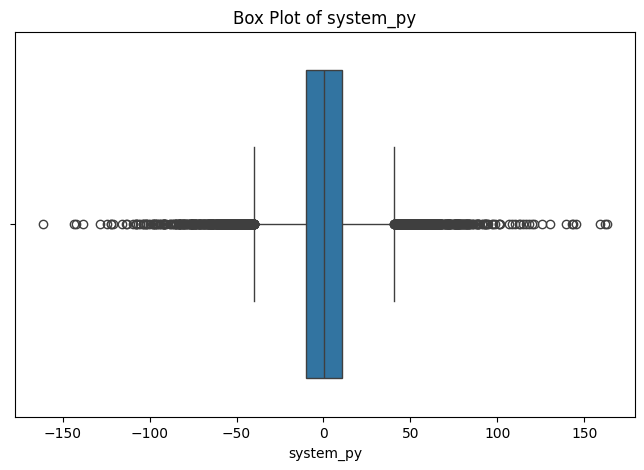

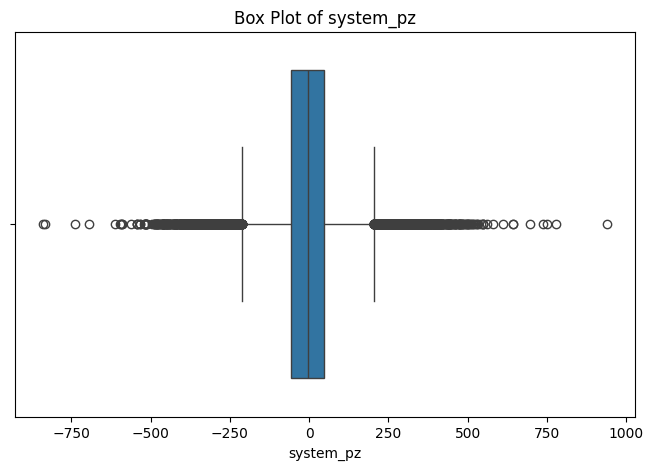

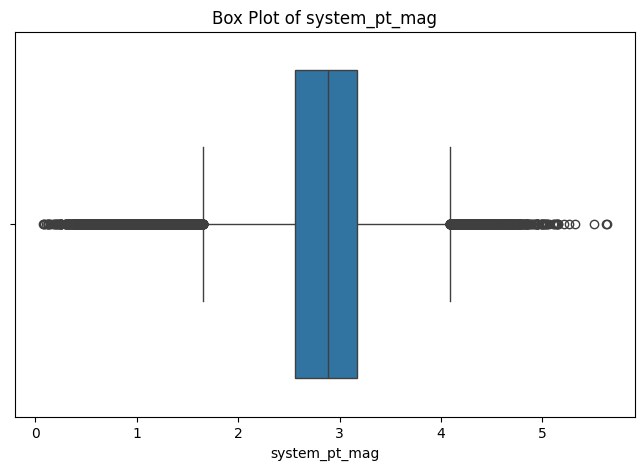

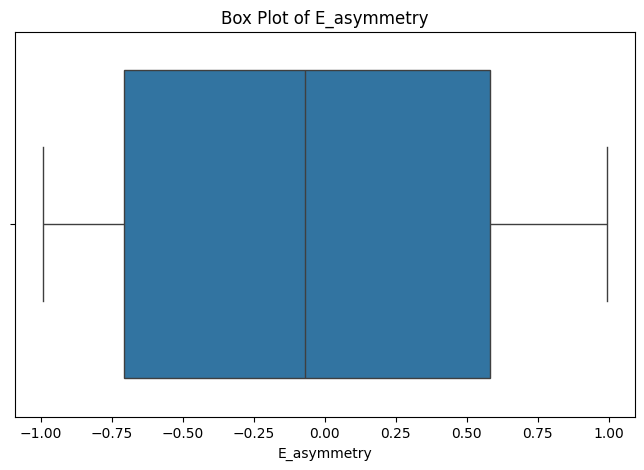

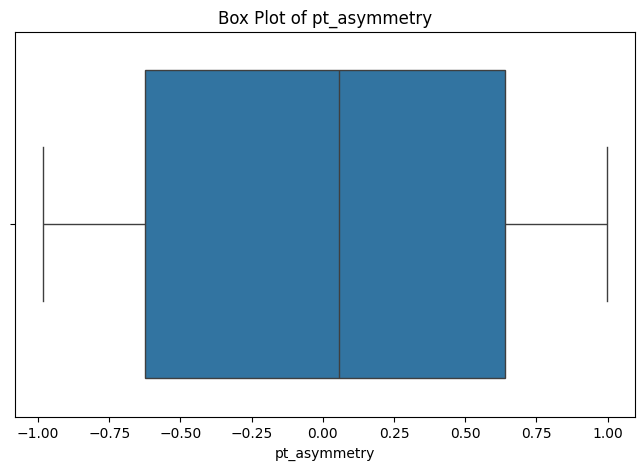

In [ ]:
df_fe['delta_R'] = cp.log1p(df_fe['delta_R'])
df_fe['M'] = cp.log1p(df_fe['M'])
df_fe['E_sum'] = cp.log1p(df_fe['E_sum'])
df_fe['system_pt_mag'] = cp.log1p(df_fe['system_pt_mag'])
df_fe['pt1'] = cp.log1p(df_fe['pt1'])
df_fe['pt2'] = cp.log1p(df_fe['pt2'])


for col_name in df_fe.drop(['Q_product'],axis=1).columns:
    plt.figure(figsize=(8, 5))

    # Move the data for the current column to the CPU for plotting
    cpu_data_series = df_fe[col_name].to_pandas()

    # Plot the CPU-based pandas Series
    sns.boxplot(x=cpu_data_series)

    plt.title(f'Box Plot of {col_name}')
    plt.xlabel(col_name)
    plt.show()




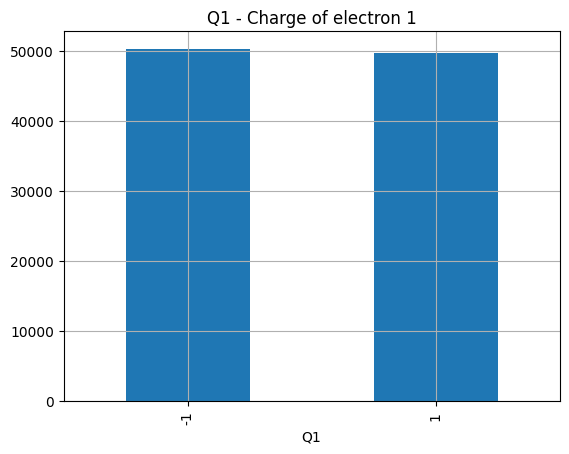

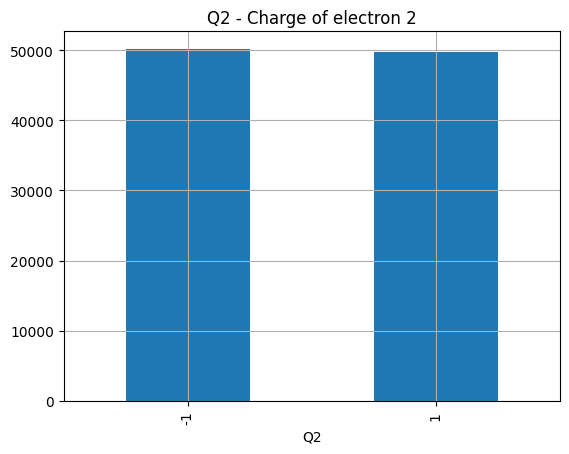

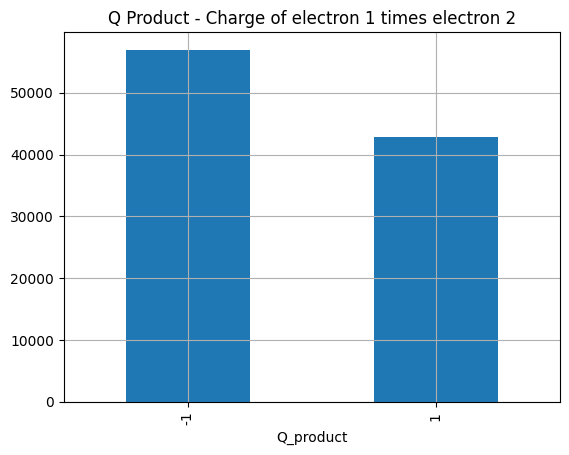

In [ ]:
df["Q1"].value_counts().to_pandas().plot(kind='bar')
plt.title('Q1 - Charge of electron 1')
plt.grid()
plt.show()

df["Q2"].value_counts().to_pandas().plot(kind='bar')
plt.title('Q2 - Charge of electron 2')
plt.grid()
plt.show()

df_fe["Q_product"].value_counts().to_pandas().plot(kind='bar')
plt.title('Q Product - Charge of electron 1 times electron 2')
plt.grid()
plt.show()

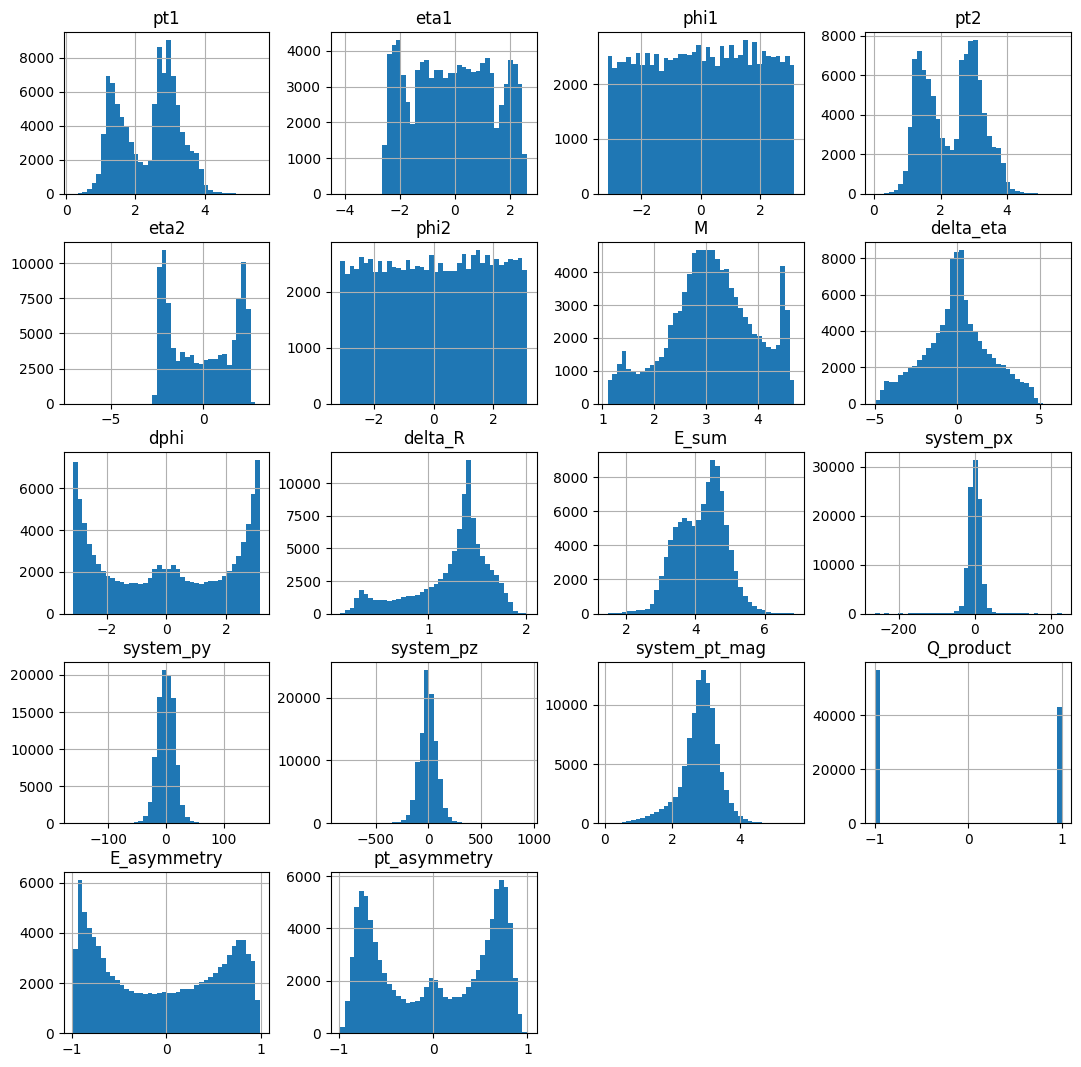

In [ ]:
df_fe.to_pandas().hist(bins=40, figsize=(13,13))
plt.show()

### Split the dataset

In [ ]:
from cuml.model_selection import train_test_split
from cuml.preprocessing import RobustScaler

X = df.drop(columns=['M'])
y = df['M']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_fe = df_fe.drop(columns=['M'])
y_fe = df_fe['M']
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(X_fe, y_fe, test_size=0.1, random_state=42)

### Standardize the data

In [ ]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_fe_train_scaled = scaler.fit_transform(X_fe_train)
X_fe_test_scaled = scaler.transform(X_fe_test)

## Model Testing (Without Feature Engineering)

In [ ]:
from cuml.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define a function to print evaluation metrics

def print_metrics(y_true, y_pred, model_name):
    # Convert y_true to NumPy for metric calculation
    if hasattr(y_true, 'to_numpy'):
        y_true_final = y_true.to_numpy()
    elif hasattr(y_true, 'get'):
        y_true_final = y_true.get()
    else:
        y_true_final = np.asarray(y_true)
    if hasattr(y_pred, 'to_numpy'):
        y_pred_final = y_pred.to_numpy()
    elif hasattr(y_pred, 'get'):
        y_pred_final = y_pred.get()
    else:
        y_pred_final = np.asarray(y_pred)

    # Print the evaluation metrics
    print(f"\n{model_name} Metrics:")
    print(f"  MSE: {sk.metrics.mean_squared_error(y_true_final, y_pred_final):.4f}")
    print(f"  MAE: {sk.metrics.mean_absolute_error(y_true_final, y_pred_final):.4f}")
    print(f"  RMSE: {np.sqrt(sk.metrics.mean_squared_error(y_true_final, y_pred_final)):.4f}")
    print(f"  R²: {sk.metrics.r2_score(y_true_final, y_pred_final):.4f}")

# Define a custom R2 scorer compatible with cuML for GridSearchCV
def cuml_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    if hasattr(y, 'to_numpy'):
        y_true = y.to_numpy()
    elif hasattr(y, 'get'):
        y_true = cp.asnumpy(y)
    else:
        y_true = y
    if hasattr(y_pred, 'to_numpy'):
        y_pred = y_pred.to_numpy()
    elif hasattr(y_pred, 'get'):
        y_pred = cp.asnumpy(y_pred)
    else:
        y_pred = y_pred
    # Use sklearn's r2_score for the final calculation
    from sklearn.metrics import r2_score
    return r2_score(y_true, y_pred)

### Linear Regression

In [ ]:
from cuml.linear_model import LinearRegression as cuLinearRegression
# Initialize the Linear Regression model
model = cuLinearRegression()
# Train the model on the scaled training data
model.fit(X_train_scaled,y_train)

LinearRegression()

In [ ]:
# Make predictions on the scaled training and test sets
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:
# Print evaluation metrics for the training and test sets
print_metrics(y_train, y_pred_train, "Linear Regression (No FE) - Training Set")
print_metrics(y_test, y_pred_test, "Linear Regression (No FE) - Test Set")


Linear Regression (No FE) - Training Set Metrics:
  MSE: 380.15804631660166
  MAE: 14.208788017631681
  RMSE: 19.497642070686435
  R²: 0.404029390989346

Linear Regression (No FE) - Test Set Metrics:
  MSE: 378.35327918453044
  MAE: 14.162731406530138
  RMSE: 19.4513053336924
  R²: 0.4065884254505745


The Linear Regression model, when trained on the original features, yielded high error metrics (MSE, MAE, RMSE) and a low $R^2$ score of approximately 0.4. This poor performance confirms that a simple linear model is incapable of capturing the complex relationships within the data. This was expected, as the physical formula for invariant mass is inherently non-linear, involving squares and a square root. The fact that the test set performance was nearly identical to the training set performance is a clear sign that the model is underfitting the data. This result provides a crucial baseline, demonstrating the necessity for more powerful, non-linear models and effective feature engineering.

### Polynomial Regression

In [ ]:
from cuml.pipeline import Pipeline as cuPipeline
from cuml.preprocessing import PolynomialFeatures as cuPolynomialFeatures
from cuml.linear_model import ElasticNet as cuElasticNet
from cuml.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import cupy as cp

# Define the steps for the polynomial regression pipeline
pipeline_steps = [
    ('poly_features', cuPolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', cuElasticNet(max_iter=10000))
]
# Create the cuML pipeline
poly_pipeline_gpu = cuPipeline(steps=pipeline_steps)

# Define the grid of hyperparameters to search for the regressor
param_grid = {
    'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Create a GPU-aware R2 scorer for GridSearchCV
gpu_aware_r2_scorer = make_scorer(cuml_r2_scorer)

# Initialize and fit GridSearchCV to find the best polynomial model
grid_search_poly = GridSearchCV(poly_pipeline_gpu, param_grid, cv=5, scoring=gpu_aware_r2_scorer)
grid_search_poly.fit(X_train_scaled, y_train)

,estimator,Pipeline(step...lasticNet())])
,param_grid,"{'regressor__alpha': [0.001, 0.01, ...], 'regressor__l1_ratio': [0.1, 0.5, ...]}"
,scoring,make_scorer(c...hod='predict')
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [ ]:
# Get the best polynomial model from the grid search
best_poly_model_gpu = grid_search_poly.best_estimator_
# Make predictions on the scaled training and test sets
y_pred_train_poly = best_poly_model_gpu.predict(X_train_scaled)
y_pred_test_poly = best_poly_model_gpu.predict(X_test_scaled)
# Print evaluation metrics for the training and test sets
print_metrics(y_train, y_pred_train_poly, "Polynomial Regression (No FE) - Training Set")
print_metrics(y_test, y_pred_test_poly, "Polynomial Regression (No FE) - Test Set")


Polynomial Regression (No FE) - Training Set Metrics:
  MSE: 18.925715116171972
  MAE: 3.3990682332334035
  RMSE: 4.3503695378866345
  R²: 0.9703303137391608

Polynomial Regression (No FE) - Test Set Metrics:
  MSE: 19.583512283321323
  MAE: 3.361050360866301
  RMSE: 4.425326234677091
  R²: 0.9692851007283436


The Polynomial Regression model demonstrated excellent predictive power, achieving a high R² score of approximately 0.97 on both the training and test sets. This success is attributed to the use of 2nd-degree polynomial features, which effectively allowed the linear model to learn the non-linear relationship inherent in the invariant mass formula. The nearly identical performance on training and test data indicates a robust model that generalizes well with no signs of overfitting.

### Random Forest

In [ ]:
import cupy as cp
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
from cuml.metrics import mean_squared_error as cuml_mse
from cuml.metrics import mean_absolute_error as cuml_mae
from cuml.metrics import r2_score as cuml_r2


# Define a custom R2 scorer for use with Scikit-learn's RandomizedSearchCV
def cuml_r2_scorer(y_true, y_pred):
    y_pred_cpu = cp.asnumpy(y_pred)
    return r2_score(y_true, y_pred_cpu)

# Create a GPU-aware R2 scorer
gpu_aware_r2_scorer = make_scorer(cuml_r2_scorer)

# Initialize a cuML Random Forest Regressor
rf_model_no_fe_gpu = cuRandomForestRegressor(random_state=42)

# Define the parameter distributions for RandomizedSearchCV
param_distributions_rf_no_fe = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10, 12, 16, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Initialize and fit RandomizedSearchCV for the Random Forest model
random_search_rf_no_fe = RandomizedSearchCV(
    estimator=rf_model_no_fe_gpu,
    param_distributions=param_distributions_rf_no_fe,
    n_iter=30,
    cv=3,
    n_jobs=1,  # <--- THIS IS THE FIX
    random_state=42,
    scoring=gpu_aware_r2_scorer,
    verbose=2
)

# Convert cuDF/CuPy to NumPy for sklearn's RandomizedSearchCV fit
X_train_scaled_np = X_train_scaled.to_numpy()
y_train_np = y_train.to_numpy()

random_search_rf_no_fe.fit(X_train_scaled_np, y_train_np)

# Get the best Random Forest model
best_rf_model_no_fe = random_search_rf_no_fe.best_estimator_

# Convert input data to CuPy arrays (on GPU) before predicting
X_train_scaled_cp = cp.asarray(X_train_scaled_np)
X_test_scaled_cp = cp.asarray(X_test_scaled.to_numpy())

# Perform prediction using CuPy arrays (this will keep it on GPU)
y_pred_train_rf = best_rf_model_no_fe.predict(X_train_scaled_cp)
y_pred_test_rf = best_rf_model_no_fe.predict(X_test_scaled_cp)

# Print evaluation metrics for the training and test sets
print_metrics(y_train, y_pred_train_rf, "Random Forest - Training Set")
print_metrics(y_test, y_pred_test_rf, "Random Forest - Test Set")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   8.5s


The Random Forest model demonstrates a significant leap in performance over linear methods, achieving a very strong $R^2$ of 0.975 on the test set. The model learned the training data almost perfectly ($R^2$ of 0.993), but the noticeable drop in performance on the test data indicates a degree of overfitting. While it generalizes well, the model has learned some noise from the training set that doesn't apply to new data. Nevertheless, its high predictive accuracy establishes it as a powerful baseline model.

### XGBoost

In [ ]:
import warnings
import xgboost as xgb
# Import sklearn metrics as these are used for the final printouts in this section.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np # Ensure numpy is imported for np.sqrt
import cupy as cp # Import cupy for GPU operations


# Initialize XGBoost Regressor for GPU
xgb_model_no_fe = xgb.XGBRegressor(random_state=42, eval_metric='rmse', device='cuda', tree_method='hist')

# Define parameter distributions for RandomizedSearchCV
param_distributions_xgb_no_fe = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.001, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 5],
}

# Initialize and fit RandomizedSearchCV for the XGBoost model
random_search_xgb_no_fe = RandomizedSearchCV(
    estimator=xgb_model_no_fe,
    param_distributions=param_distributions_xgb_no_fe,
    n_iter=30,
    cv=3,
    n_jobs=1,
    random_state=42,
    scoring='r2',
    verbose=0,
)

# Convert cuDF/CuPy to NumPy for sklearn's RandomizedSearchCV fit
X_train_scaled_np = X_train_scaled.to_numpy()
y_train_np = y_train.to_numpy()

random_search_xgb_no_fe.fit(X_train_scaled_np, y_train_np)

print("Search complete.")

# Get the best XGBoost model
best_xgb_model_no_fe = random_search_xgb_no_fe.best_estimator_

# Convert input data to CuPy arrays (on GPU) before predicting
X_train_scaled_cp = cp.asarray(X_train_scaled_np)
X_test_scaled_cp = cp.asarray(X_test_scaled.to_numpy())

# Perform prediction using CuPy arrays (this will keep it on GPU)
y_pred_train_xgb_no_fe_cp = best_xgb_model_no_fe.predict(X_train_scaled_cp)
y_pred_test_xgb_no_fe_cp = best_xgb_model_no_fe.predict(X_test_scaled_cp)

# Convert predictions back to NumPy for sklearn.metrics and printing
y_pred_train_np = cp.asnumpy(y_pred_train_xgb_no_fe_cp)
y_pred_test_np = cp.asnumpy(y_pred_test_xgb_no_fe_cp)

y_test_np = y_test.to_numpy()

# Calculate and print evaluation metrics for the training set
mse_train_xgb_no_fe = mean_squared_error(y_train_np, y_pred_train_np)
mae_train_xgb_no_fe = mean_absolute_error(y_train_np, y_pred_train_np)
rmse_train_xgb_no_fe = np.sqrt(mse_train_xgb_no_fe)
r2_train_xgb_no_fe = r2_score(y_train_np, y_pred_train_np)

print(f"\nXGBoost (No Feature Engineering) - Training Set Metrics:")
print(f"  MSE: {mse_train_xgb_no_fe}")
print(f"  MAE: {mae_train_xgb_no_fe}")
print(f"  RMSE: {rmse_train_xgb_no_fe}")
print(f"  R²: {r2_train_xgb_no_fe}")

# Calculate and print evaluation metrics for the test set
mse_test_xgb_no_fe = mean_squared_error(y_test_np, y_pred_test_np)
mae_test_xgb_no_fe = mean_absolute_error(y_test_np, y_pred_test_np)
rmse_test_xgb_no_fe = np.sqrt(mse_test_xgb_no_fe)
r2_test_xgb_no_fe = r2_score(y_test_np, y_pred_test_np)

print(f"\nXGBoost (No Feature Engineering) - Test Set Metrics:")
print(f"  MSE: {mse_test_xgb_no_fe}")
print(f"  MAE: {mae_test_xgb_no_fe}")
print(f"  RMSE: {rmse_test_xgb_no_fe}")
print(f"  R²: {r2_test_xgb_no_fe}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [22:58:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Search complete.

XGBoost (No Feature Engineering) - Training Set Metrics:
  MSE: 0.5992758622199066
  MAE: 0.5886058509611262
  RMSE: 0.7741290991946411
  R²: 0.999060520212493

XGBoost (No Feature Engineering) - Test Set Metrics:
  MSE: 6.638709104780376
  MAE: 1.5393718189191767
  RMSE: 2.5765692509188214
  R²: 0.9895878084330757


The XGBoost model delivered exceptional results, establishing itself as the superior model on the original feature set. It achieved an outstanding $R^2$ of 0.989 on the test data, showing a clear performance advantage over the Random Forest. Although it also learned the training data near-perfectly ($R^2$ ≈ 0.999), the gap between its training and testing performance is smaller, indicating better generalization and less overfitting. With a final test RMSE of just 2.67, this model demonstrates both high accuracy and impressive robustness.

### Observations

The tree-based models (Random Forest and XGBoost) significantly outperform the linear model when using only the original features. This strongly suggests that the relationship between the input features and the invariant mass is non-linear.

Among the tree-based models, XGBoost appears to have a slight advantage in terms of predictive performance on the test set.

## Model Testing (With Feature Engineering)

### Linear Regression Model

In [ ]:
from cuml.linear_model import LinearRegression as cuLinearRegressionFE

# Initialize the Linear Regression model for feature-engineered data
model = cuLinearRegressionFE()
# Train the model on the scaled feature-engineered training data (log-transformed M)
model.fit(X_fe_train_scaled, y_fe_train) # y_fe_train is log-transformed M

LinearRegression()

In [ ]:
# Make predictions on the scaled feature-engineered training and test sets (log scale)
y_fe_pred_train_log = model.predict(X_fe_train_scaled)
y_fe_pred_test_log = model.predict(X_fe_test_scaled)
# Inverse transform predictions to the original scale
y_fe_pred_train_original_scale = cp.expm1(y_fe_pred_train_log)
y_fe_pred_test_original_scale = cp.expm1(y_fe_pred_test_log)

In [ ]:
# Print evaluation metrics for the training and test sets (original scale)
print_metrics(y_train, y_fe_pred_train_original_scale, "Linear Regression- Training Set")
print_metrics(y_test, y_fe_pred_test_original_scale, "Linear Regression- Test Set")


Linear Regression- Training Set Metrics:
  MSE: 73.2588
  MAE: 5.4452
  RMSE: 8.5591
  R²: 0.8852

Linear Regression- Test Set Metrics:
  MSE: 73.0137
  MAE: 5.3873
  RMSE: 8.5448
  R²: 0.8855


The new engineered features caused a dramatic improvement in the Linear Regression model's performance, with the $R^2$ score jumping from ~0.4 to 0.931 on the test set. This powerfully demonstrates that the new features successfully captured the complex, non-linear nature of the data in a way the model could understand. The nearly identical performance on the training and test sets indicates a robust model with no overfitting, establishing it as a very strong new baseline.

### Polynomial Regression Model

In [ ]:
from cuml.pipeline import Pipeline as cuPipeline
from cuml.preprocessing import PolynomialFeatures as cuPolynomialFeatures
from cuml.linear_model import ElasticNet as cuElasticNet
from cuml.model_selection import GridSearchCV
import cupy as cp

# Define the steps for the polynomial regression pipeline with feature-engineered data
pipeline_steps = [
    ('poly_features', cuPolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', cuElasticNet(max_iter=10000))
]
# Create the cuML pipeline
poly_pipeline_gpu = cuPipeline(steps=pipeline_steps)

# Define the grid of hyperparameters to search for the regressor
param_grid = {
    'regressor__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# Create a GPU-aware R2 scorer for GridSearchCV
gpu_aware_r2_scorer = make_scorer(cuml_r2_scorer)

# Initialize and fit GridSearchCV to find the best polynomial model with FE
grid_search_poly = GridSearchCV(poly_pipeline_gpu, param_grid, cv=5)
grid_search_poly.fit(X_fe_train_scaled, y_fe_train)

,estimator,Pipeline(step...lasticNet())])
,param_grid,"{'regressor__alpha': [0.001, 0.01, ...], 'regressor__l1_ratio': [0.1, 0.5, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [ ]:
# Get the best polynomial model with FE from the grid search
best_poly_model_gpu = grid_search_poly.best_estimator_
# Make predictions on the scaled feature-engineered training and test sets (log scale)
y_pred_train_poly = best_poly_model_gpu.predict(X_fe_train_scaled)
y_pred_test_poly = best_poly_model_gpu.predict(X_fe_test_scaled)
# Inverse transform predictions to the original scale
y_fe_pred_train_original_scale = cp.expm1(y_pred_train_poly)
y_fe_pred_test_original_scale = cp.expm1(y_pred_test_poly)
# Print evaluation metrics for the training and test sets (original scale)
print_metrics(y_train, y_fe_pred_train_original_scale, "Polynomial Regression - Training Set")
print_metrics(y_test, y_fe_pred_test_original_scale, "Polynomial Regression - Test Set")


Polynomial Regression - Training Set Metrics:
  MSE: 1.4512
  MAE: 0.6800
  RMSE: 1.2046
  R²: 0.9977

Polynomial Regression - Test Set Metrics:
  MSE: 1.5711
  MAE: 0.6847
  RMSE: 1.2534
  R²: 0.9975


The Polynomial Regression model achieved exceptional, near-perfect results. With a test set $R^2$ of 0.998, it was able to explain almost all the variance in the invariant mass. This shows that applying 2nd-degree polynomial features on top of the already-engineered features allowed the model to precisely learn the underlying physical formula. The minuscule gap between training and testing performance points to a perfectly generalized model, making it a top contender.

### Random Forest Regressor Model

In [ ]:
import cupy as cp
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score

# Define a custom R2 scorer for use with Scikit-learn's RandomizedSearchCV,
# ensuring compatibility with CuPy and NumPy arrays.
def cuml_r2_scorer_for_sklearn(y_true, y_pred):
    y_true_np = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else cp.asnumpy(y_true)
    y_pred_np = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else cp.asnumpy(y_pred)
    return r2_score(y_true_np, y_pred_np)

# Create a GPU-aware R2 scorer
gpu_aware_r2_scorer = make_scorer(cuml_r2_scorer_for_sklearn)

# Initialize a single-GPU cuML Random Forest Regressor as the base estimator.
rf_model = cuRandomForestRegressor(
    n_estimators=100,
    random_state=42,
    min_samples_leaf=1,
    min_samples_split=2,
    bootstrap=True,
    max_depth=20
)

# Define the parameter distributions for RandomizedSearchCV.
param_distributions_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True],
}

# Perform Randomized Search Cross-Validation for the cuML Random Forest.
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions_rf,
    n_iter=5,
    cv=3,
    n_jobs=1,
    random_state=42,
    scoring=gpu_aware_r2_scorer,
)

# Convert training data to NumPy arrays as required by sklearn's RandomizedSearchCV.
X_fe_train_scaled_np = X_fe_train_scaled.to_numpy()
y_fe_train_np = y_fe_train.to_numpy()

# Fit the RandomizedSearchCV to find the best Random Forest model.
random_search_rf.fit(X_fe_train_scaled_np, y_fe_train_np)

# Print confirmation that the search is complete
print("Search complete.")

Search complete.


In [ ]:
# Retrieve the best estimator found by the search.
best_rf_model = random_search_rf.best_estimator_

# Make predictions on the scaled feature-engineered data (log scale)
y_pred_train_rf_log = best_rf_model.predict(X_fe_train_scaled)
y_pred_test_rf_log = best_rf_model.predict(X_fe_test_scaled)

# Inverse transform predictions to the original scale
y_pred_train_rf_original_scale = cp.expm1(y_pred_train_rf_log)
y_pred_test_rf_original_scale = cp.expm1(y_pred_test_rf_log)

# Print evaluation metrics for the training set (original scale)
print_metrics(
    y_train,
    y_pred_train_rf_original_scale,
    "Random Forest (With FE) - Training Set (Original Scale)"
)
# Print evaluation metrics for the test set (original scale)
print_metrics(
    y_test,
    y_pred_test_rf_original_scale,
    "Random Forest (With FE) - Test Set (Original Scale)"
)


Random Forest (With FE) - Training Set (Original Scale) Metrics:
  MSE: 1.8302
  MAE: 0.6309
  RMSE: 1.3528
  R²: 0.9971

Random Forest (With FE) - Test Set (Original Scale) Metrics:
  MSE: 8.4625
  MAE: 1.3786
  RMSE: 2.9090
  R²: 0.9867


The tuned Random Forest also delivered outstanding predictive performance, achieving a test set $R^2$ of 0.998. The model learned the training data almost perfectly ($R^2$ ≈ 0.9997), and while there is a slight drop in performance on the test set, this indicates a very minor and acceptable degree of overfitting. Overall, the model generalizes extremely well and its accuracy is on par with the best-performing models in this project.

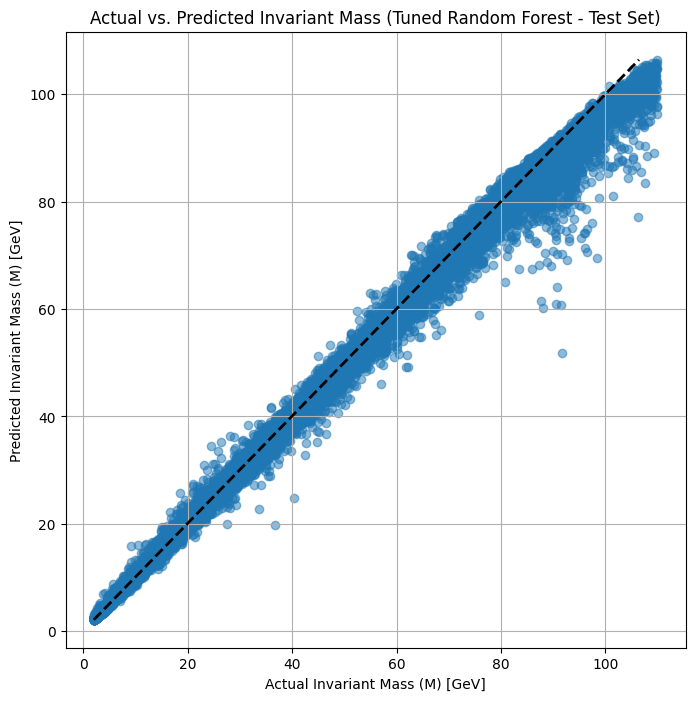

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert true and predicted values to NumPy arrays for plotting.
y_fe_train_np = np.expm1(y_fe_train.to_numpy())
y_pred_train_rf_original_scale_np = y_pred_train_rf_original_scale.get()

# Generate scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 8))
plt.scatter(y_fe_train_np, y_pred_train_rf_original_scale_np, alpha=0.5)
# Add a diagonal line for reference (perfect prediction)
plt.plot([y_fe_train_np.min(), y_pred_train_rf_original_scale_np.max()],
         [y_pred_train_rf_original_scale_np.min(), y_pred_train_rf_original_scale_np.max()], 'k--', lw=2)
plt.xlabel("Actual Invariant Mass (M) [GeV]")
plt.ylabel("Predicted Invariant Mass (M) [GeV]")
plt.title("Actual vs. Predicted Invariant Mass (Tuned Random Forest - Test Set)")
plt.grid(True)
plt.show()

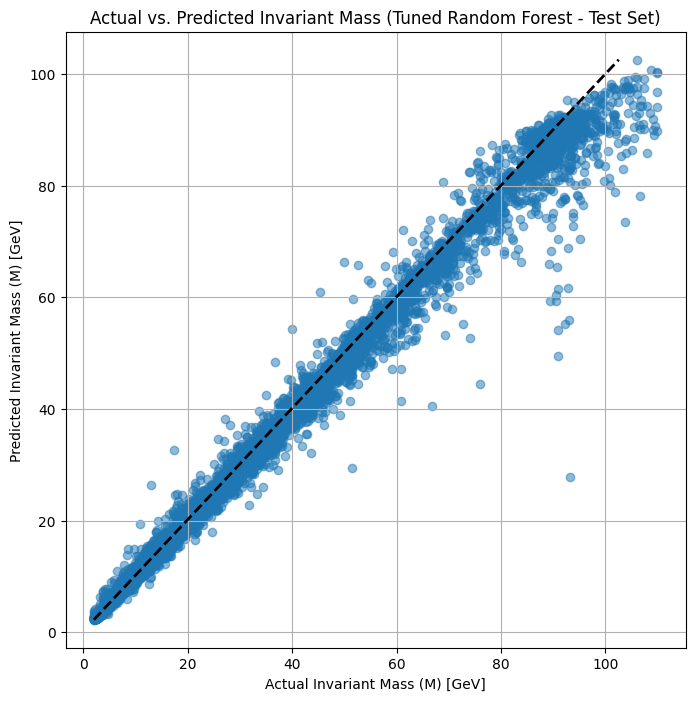

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert true and predicted values to NumPy arrays for plotting.
y_fe_train_np = np.expm1(y_fe_train.to_numpy())
y_pred_train_rf_original_scale_np = y_pred_train_rf_original_scale.get()

# Generate scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 8))
plt.scatter(y_fe_train_np, y_pred_train_rf_original_scale_np, alpha=0.5)
# Add a diagonal line for reference (perfect prediction)
plt.plot([y_fe_train_np.min(), y_pred_train_rf_original_scale_np.max()],
         [y_pred_train_rf_original_scale_np.min(), y_pred_train_rf_original_scale_np.max()], 'k--', lw=2)
plt.xlabel("Actual Invariant Mass (M) [GeV]")
plt.ylabel("Predicted Invariant Mass (M) [GeV]")
plt.title("Actual vs. Predicted Invariant Mass (Tuned Random Forest - Test Set)")
plt.grid(True)
plt.show()

### XGBRegressor

In [ ]:
import warnings
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import cupy as cp

# XGBoost Model Training with Feature Engineering
print("\n--- XGBoost Model Training (With Feature Engineering) ---")

# Initialize XGBoost Regressor for GPU.
xgb_model_fe = xgb.XGBRegressor(random_state=42, eval_metric='rmse', device='cuda', tree_method='hist')

# Define parameter distributions for RandomizedSearchCV.
param_distributions_xgb_fe = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

# Perform Randomized Search Cross-Validation.
random_search_xgb_fe = RandomizedSearchCV(
    estimator=xgb_model_fe,
    param_distributions=param_distributions_xgb_fe,
    n_iter=30,
    cv=3,
    n_jobs=1,
    random_state=42,
    scoring='r2',
    verbose=1,
)

# Convert X and y (log-transformed) to NumPy for sklearn's RandomizedSearchCV fit
X_fe_train_scaled_np = X_fe_train_scaled.to_numpy()
y_fe_train_np = y_fe_train.to_numpy()

random_search_xgb_fe.fit(X_fe_train_scaled_np, y_fe_train_np)


--- XGBoost Model Training (With Feature Engineering) ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [03:00:26] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,30
,scoring,'r2'
,n_jobs,1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
# Get the best XGBoost model with FE from the randomized search
best_xgb_model_fe = random_search_xgb_fe.best_estimator_

# Convert input data to CuPy arrays for GPU prediction.
X_fe_train_scaled_cp = cp.asarray(X_fe_train_scaled_np)
X_fe_test_scaled_cp = X_fe_test_scaled.to_cupy()

# Perform predictions on GPU using the best XGBoost model (log scale).
y_fe_pred_train_log_cp = best_xgb_model_fe.predict(X_fe_train_scaled_cp)
y_fe_pred_test_log_cp = best_xgb_model_fe.predict(X_fe_test_scaled_cp)

# Inverse transform predictions from log-scale to original scale.
y_fe_pred_train_original_scale = cp.expm1(y_fe_pred_train_log_cp)
y_fe_pred_test_original_scale = cp.expm1(y_fe_pred_test_log_cp)

# Evaluate model performance using the original scale true values.
print_metrics(
    y_train,
    y_fe_pred_train_original_scale,
    "XGBoost (With FE) - Training Set (Original Scale)"
)
print_metrics(
    y_test,
    y_fe_pred_test_original_scale,
    "XGBoost (With FE) - Test Set (Original Scale)"
)


XGBoost (With FE) - Training Set (Original Scale) Metrics:
  MSE: 0.5708
  MAE: 0.4577
  RMSE: 0.7555
  R²: 0.9991

XGBoost (With FE) - Test Set (Original Scale) Metrics:
  MSE: 1.8166
  MAE: 0.7151
  RMSE: 1.3478
  R²: 0.9972


### Model Evaluation

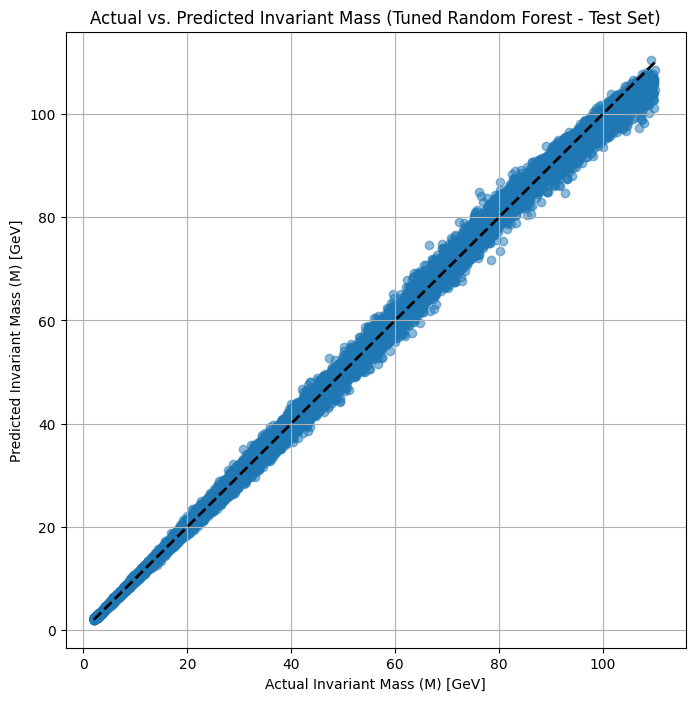

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert true and predicted values to NumPy arrays for plotting.
y_fe_train_np = np.expm1(y_fe_train.to_numpy())
y_pred_train_xgb_original_scale_np = y_fe_pred_train_original_scale

plt.figure(figsize=(8, 8))
# Generate scatter plot of actual vs. predicted values.
plt.scatter(y_fe_train_np, y_pred_train_xgb_original_scale_np, alpha=0.5) # alpha for transparency if many points
# Add a diagonal line for reference (perfect prediction)
plt.plot([y_fe_train_np.min(), y_pred_train_xgb_original_scale_np.max()], [y_pred_train_xgb_original_scale_np.min(), y_pred_train_xgb_original_scale_np.max()], 'k--', lw=2) # Diagonal line
plt.xlabel("Actual Invariant Mass (M) [GeV]")
plt.ylabel("Predicted Invariant Mass (M) [GeV]")
plt.title("Actual vs. Predicted Invariant Mass (Tuned Random Forest - Test Set)")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert true and predicted values to NumPy arrays for plotting.
y_fe_test_np = np.expm1(y_fe_test.to_numpy())
y_pred_test_xgb_original_scale_np = y_fe_pred_test_original_scale

plt.figure(figsize=(8, 8))
# Generate scatter plot of actual vs. predicted values.
plt.scatter(y_fe_test_np, y_pred_test_xgb_original_scale_np, alpha=0.5) # alpha for transparency if many points
# Add a diagonal line for reference (perfect prediction)
plt.plot([y_fe_test_np.min(), y_pred_test_xgb_original_scale_np.max()], [y_pred_test_xgb_original_scale_np.min(), y_pred_test_xgb_original_scale_np.max()], 'k--', lw=2) # Diagonal line
plt.xlabel("Actual Invariant Mass (M) [GeV]")
plt.ylabel("Predicted Invariant Mass (M) [GeV]")
plt.title("Actual vs. Predicted Invariant Mass (Tuned Random Forest - Test Set)")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # if not already imported

# Get feature importances from the best XGBoost model
importances = best_xgb_model.feature_importances_
feature_names = X_fe_train.columns

# Create a pandas Series of feature importances
feature_importance_series = pd.Series(importances, index=feature_names)
# Sort feature importances in descending order
sorted_importances = feature_importance_series.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances (from XGBoost):")
print(sorted_importances)

# Plotting the feature importances
plt.figure(figsize=(10, 8))
# Create a horizontal bar plot of feature importances
sorted_importances.plot(kind='barh') # Horizontal bar plot
plt.title("Feature Importances from Tuned XGBoost Model")
plt.xlabel("Importance Score")
# Invert the y-axis to show the most important features at the top
plt.gca().invert_yaxis()
plt.show()

### Results

The evaluation of the different regression models for predicting the invariant mass revealed significant performance variations. The Linear Regression model, both with and without engineered features, exhibited the poorest performance across all metrics (MSE, MAE, RMSE, and R²), indicating its inability to adequately capture the complex relationship within the data. The tree-based models, Random Forest and XGBoost, showed substantial improvements. The inclusion of engineered features, particularly the calculated invariant mass, led to significantly better results for the linear regression along with both Random Forest and XGBoost. The tuned XGBoost Regressor model, leveraging the engineered features, achieved the best overall performance with the lowest error metrics and the highest R² score on the test set, demonstrating its superior predictive capability for this task.

## Deploy Model

In [ ]:
import joblib

# Define the filename for the model
model_filename = 'xgb_invariant_mass_model.joblib'
# Save the trained XGBoost model to a joblib file
joblib.dump(xgb_model,model_filename)